<a href="https://colab.research.google.com/github/frasercrichton/fastai2-learning/blob/master/TripleChaserFastAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
bs = 64     # default batch size
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fastai2 -q
!pip install utils
from utils import *
from fastai2.vision.all import *

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  15926      0 --:--:-- --:--:-- --:--:-- 16325
OK
59 packages can be upgraded. Run 'apt list --upgradable' to see them.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 184kB 2.7MB/s 


Authenticate against GCP related

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!rm -rf "data" 
!mkdir "data"
!rm -rf "download" 
!mkdir "download"
project_id = "forensic-265906"
!gcloud config set project {project_id}
!gsutil -m cp -r gs://forensic-architecture-machine-learning/canisters/canisters.zip download/canisters.zip


Updated property [core/project].
Copying gs://forensic-architecture-machine-learning/canisters/canisters.zip...
\ [1/1 files][276.4 MiB/276.4 MiB] 100% Done                                    
Operation completed over 1 objects/276.4 MiB.                                    


In [7]:
%%capture
!rm -rf "data" 
!unzip "download/canisters.zip" 

## Examine the contents of the bucket

Lets get the bucket and have a look at how it's annotated . . .

In [8]:
!ls data/canisters/real_val/

ann  img


In [9]:
path = Path('data/canisters/real_val/'); path

Path('data/canisters/real_val')

Now lets see some of those images

In [10]:
annotations_path = path/'ann'
images_path = path /'img'
 #augmentations = augmentations

fnames = get_image_files(images_path)
fnames

(#265) [Path('data/canisters/real_val/img/20190220__1550160362092.jpeg'),Path('data/canisters/real_val/img/1550245647058.png'),Path('data/canisters/real_val/img/zbatch2__@albertopradilla-tijuananov2018.jpeg'),Path('data/canisters/real_val/img/1550488922539.jpeg'),Path('data/canisters/real_val/img/zbatch2__oakland2010body.png'),Path('data/canisters/real_val/img/zbatch2__venez07deftechmix.png'),Path('data/canisters/real_val/img/1548937141141.png'),Path('data/canisters/real_val/img/20190220__1550488251633.png'),Path('data/canisters/real_val/img/1550488921318.jpeg'),Path('data/canisters/real_val/img/1550488919712.jpeg')...]

In [18]:
images = list(
  sorted(
    filter(
      lambda _pth: _pth.suffix.lstrip(".").lower()
      in {"jpg", "png"},
      images_path.iterdir(),
    )
  )
)
images

NameError: ignored

In [19]:

annotations = [
   annotations_path / f"{image_file.name}.json"             
   for image_file in images
  ]
annotations



[Path('data/canisters/real_val/ann/1548757385802.png.json'),
 Path('data/canisters/real_val/ann/1548757432354.png.json'),
 Path('data/canisters/real_val/ann/1548758142404.png.json'),
 Path('data/canisters/real_val/ann/1548758242906.png.json'),
 Path('data/canisters/real_val/ann/1548758656546.png.json'),
 Path('data/canisters/real_val/ann/1548759102342.png.json'),
 Path('data/canisters/real_val/ann/1548760975960.png.json'),
 Path('data/canisters/real_val/ann/1548772649231.png.json'),
 Path('data/canisters/real_val/ann/1548772650097.png.json'),
 Path('data/canisters/real_val/ann/1548772651231.png.json'),
 Path('data/canisters/real_val/ann/1548772728958.png.json'),
 Path('data/canisters/real_val/ann/1548937065136.png.json'),
 Path('data/canisters/real_val/ann/1548937141141.png.json'),
 Path('data/canisters/real_val/ann/1549036457913.png.json'),
 Path('data/canisters/real_val/ann/1549063622990.png.json'),
 Path('data/canisters/real_val/ann/1549063639048.png.json'),
 Path('data/canisters/re

In [23]:
idx = 4
annotation_data = json.loads(annotations[idx].read_text())
annotation_data

{'description': '',
 'objects': [{'bitmap': None,
   'classTitle': 'triplechaser',
   'description': '',
   'points': {'exterior': [[23.0, 5.0], [111.0, 192.0]], 'interior': []},
   'tags': [{'name': '3', 'value': None}]},
  {'bitmap': None,
   'classTitle': 'triplechaser',
   'description': '',
   'points': {'exterior': [[117.0, 1.0], [203.0, 190.0]], 'interior': []},
   'tags': [{'name': '2', 'value': None}]},
  {'bitmap': None,
   'classTitle': 'triplechaser',
   'description': '',
   'points': {'exterior': [[209.0, 5.0], [294.0, 192.0]], 'interior': []},
   'tags': [{'name': '1', 'value': None}]},
  {'bitmap': {'data': 'eJwBJQHa/olQTkcNChoKAAAADUlIRFIAAABXAAAAuAEDAAAArBTieAAAAAZQTFRFAAAA////pdmf3QAAAAF0Uk5TAEDm2GYAAADNSURBVHic3dbRDYMgEADQa/zgkxEYhdF0NEdxBPpHE8qVAOJpQdHU2MjXIxA4LhAOAIAhYgehtc59tHQeiFW0cNYQetzZSJ3set7M23658UbvR3BHHLYOHohVwZrYkHXsTps1NwWzeusj5t9WdUbNxxy2OLYa9zPjRS7Fc7blRRZZd7stt/wmfnXT2Q9Ybvk5t/iF1dlOj8g/u3+zyNnAlOeF24IxZ0vm1HhlX+pszDe2zFnd15y4IU4Xq4eUIEt+OLWsAMKAiTUG

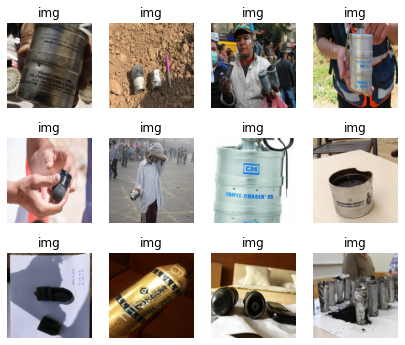

In [12]:
    
def label_func(x): return x.parent.name
# get the annotations json
 
# get the class title 
 #      print("annotation_data", annotation_data["objects"])
  #        item
  #          for item in data["objects"]
  #          if item["classTitle"][-6:] == "bitmap"
 

dls = ImageDataLoaders.from_path_func(images_path, fnames, label_func,
                                      item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=bs//2,
                                     batch_tfms=[*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)])
# , item_tfms=Resize(460), bs=bs, batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
dls.show_batch(max_n=12, figsize=(7,6))

In [ ]:
print(dls.vocab)
len(dls.vocab),dls.c

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fit_one_cycle(10)